In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import os

In [2]:
traindir = "D:/gender_classification/Training"
validdir = "D:/gender_classification/Validation"
os.listdir(traindir)

['female', 'male']

In [3]:
def show_image(dir):
    plt.figure(figsize=(12,7))
    for i in range(10):
        plt.subplot(2,5,i+1)
        img = random.choice(os.listdir(dir))
        img = load_img(os.path.join(dir,img))
        plt.subplots_adjust(hspace=0.2)
        x =dir.split("/")[-1]
        if x == "male":
            plt.suptitle("Male Images",fontsize=15)
        else:
            plt.suptitle("Female Images",fontsize=15)
        plt.imshow(img)
    plt.tight_layout()

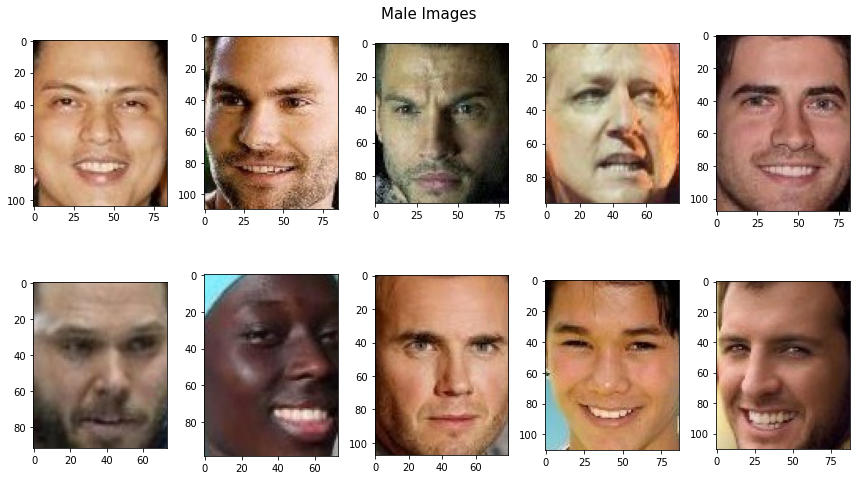

In [4]:
show_image("D:/gender_classification/Training/male")

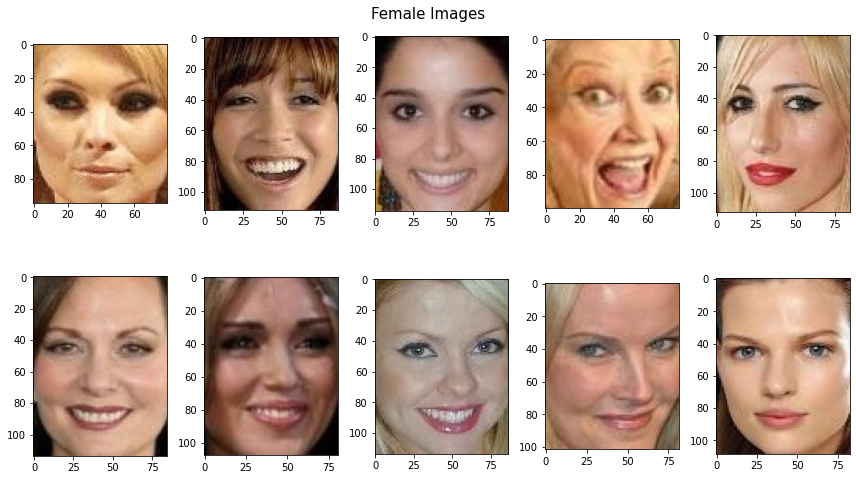

In [5]:
show_image("D:/gender_classification/Training/female")

In [6]:
height = 150
width = 150
train_datagen =  ImageDataGenerator(rescale = 1/255.0,rotation_range=15,height_shift_range=0.5,shear_range=0.5,
                              zoom_range=0.2,validation_split=0.2,horizontal_flip=True)

train_data = train_datagen.flow_from_directory(directory = traindir,target_size=(height,width),
                                               class_mode = "categorical",batch_size=32,subset="training")

val_datagen = ImageDataGenerator(rescale = 1/255.0,rotation_range=15,height_shift_range=0.5,shear_range=0.5,
                              zoom_range=0.2,validation_split=0.2,horizontal_flip=True)

val_data = train_datagen.flow_from_directory(directory = traindir,target_size=(height,width),
                                               class_mode = "categorical",batch_size=32,subset="validation")

Found 37608 images belonging to 2 classes.
Found 9401 images belonging to 2 classes.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPool2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [11]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
mobilenet = MobileNetV2(weights = "imagenet",include_top = False,input_shape=(height,width,3))

for layer in mobilenet.layers:
    layer.trainable = False

model = Sequential()
model.add(mobilenet)
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(2,activation = "softmax"))

model.compile(optimizer=Adam(lr=0.001),loss = "categorical_crossentropy",metrics =["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 5, 5, 128)         163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6402      
Total params: 2,428,354
Trainable params: 170,370
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
checkpoint = ModelCheckpoint("Gender_classification_model.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
earlystop = EarlyStopping(monitor='val_acc',patience=5,verbose=1)

In [13]:
batch_size = 64
history = model.fit_generator(train_data,steps_per_epoch = 70,epochs=20,
                              validation_data = val_data,validation_steps = 70,
                              callbacks = [checkpoint,earlystop],verbose=1)

Epoch 1/20
70/70 [==============================] - 58s 808ms/step - loss: 1.5340 - accuracy: 0.5955 - val_loss: 0.4718 - val_accuracy: 0.7741

Epoch 00001: val_accuracy improved from -inf to 0.77411, saving model to Gender_classification_model.h5
Epoch 2/20
70/70 [==============================] - 62s 890ms/step - loss: 0.4738 - accuracy: 0.7791 - val_loss: 0.4187 - val_accuracy: 0.8085

Epoch 00002: val_accuracy improved from 0.77411 to 0.80848, saving model to Gender_classification_model.h5
Epoch 3/20
70/70 [==============================] - 68s 971ms/step - loss: 0.4397 - accuracy: 0.8040 - val_loss: 0.3656 - val_accuracy: 0.8424

Epoch 00003: val_accuracy improved from 0.80848 to 0.84241, saving model to Gender_classification_model.h5
Epoch 4/20
70/70 [==============================] - 59s 840ms/step - loss: 0.4401 - accuracy: 0.8123 - val_loss: 0.3680 - val_accuracy: 0.8384

Epoch 00004: val_accuracy did not improve from 0.84241
Epoch 5/20
70/70 [==============================] -

In [ ]:
import matplotlib.pyplot as plt

# Training results of network



plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


# Set the parameters
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper right')

# Display the plots
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])



# Set the parameters
plt.title('Deep learning model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper right')

# Display the plots
plt.show()

# Test the model from camera

In [ ]:
def checking(image):
    label = {0:"female",1:"male"} 
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    cascade = cv2.CascadeClassifier(classifier_path)
    faces = cascade.detectMultiScale(gray,1.1,7)#1.1
    
    for x,y,w,h in faces:
        face = image[y:y+h,x:x+w]
        face = cv2.resize(face,(150,150))
        img_scaled = face/255.0
        reshape = np.reshape(img_scaled,(1,150,150,3))
        img = np.vstack([reshape])
        prediction=int(np.amax(model.predict(img))*100)
        result=np.argmax(model.predict(img))
        
        if result < 0.5:
            cv2.rectangle(image,(x-10,y),(x+w,y+h),(0,255,0),4)
            cv2.rectangle(image,(x-10,y-50),(x+w,y),(255,0,0),-1)
            cv2.putText(image,label[0]+":%"+str(prediction),(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,0),2)
            #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            cv2.imshow("frame",image)
            
        
            
        elif result > 0.5:
            cv2.rectangle(image,(x-10,y),(x+w,y+h),(0,255,0),4)
            cv2.rectangle(image,(x-10,y-50),(x+w,y),(255,0,0),-1)
            cv2.putText(image,label[1]+":%"+str(prediction),(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,0),2)
            #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            cv2.imshow("frame",image)
plt.show()
cv2.destroyAllWindows()

In [ ]:
cap = cv2.VideoCapture(0)
import time

while True:
    start=time.time()
    ret, frame = cap.read()
    
    if ret==True:
        checking(frame)
        #cv2.imshow("gender",frame)
        end=time.time()
        print(f"Runtime of the program is {end - start}")
        if cv2.waitKey(1) & 0xFF == ord("q"): 
            cv2.destroyAllWindows()
            cap.release()
            break
            
